In [1]:
# Задание 1. A/B–тестирование

In [17]:
# Импортируем все необходимые библиотеки и считаем файлы.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy.stats import chi2_contingency
from tqdm.auto import tqdm

In [18]:
groups = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-sulimenko-18/Проект_2_groups.csv", sep=';')

In [19]:
groups_add = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-sulimenko-18/Проект_2_group_add.csv", sep=',')

In [20]:
active_studs = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-sulimenko-18/Проект_2_active_studs.csv")

In [21]:
checks = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-sulimenko-18/Проект_2_checks.csv", sep=';')

In [7]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [8]:
groups.shape[0]

74484

In [9]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [10]:
groups_add.shape[0]

92

In [10]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [12]:
active_studs.shape[0]

8341

In [11]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [22]:
active_studs = active_studs.rename(columns={'student_id': 'id'})
# переименовали столбец, чтобы удобно потом было соединять данные

In [23]:
checks = checks.rename(columns={'student_id': 'id'})  # переименовали столбец, чтобы удобно потом было соединять данные

In [24]:
groups_all = pd.concat([groups, groups_add])  # присоединили дополнительные данные

In [25]:
# посмотрим на всех пользователей с чеком
groups_checks = groups_all.merge(checks, how='left', on=['id'])  # соединили 2 датафрейма groups и checks по id
groups_checks.head()

,id,grp,rev
0,1489,B,NaN
1,1627,A,990.0
2,1768,B,NaN
3,1783,B,NaN
4,1794,A,NaN


In [26]:
# посмотрим все ли были активны, кто оплатил
active_studs['active'] = 'active'  # создали столбец с пометкой 'активный'
active_or_not = groups_checks.merge(active_studs, how='left', on=['id']) 
active_or_not = active_or_not.query('active != "active" and rev != "NaN"')  # отобрали неактивных, но платящих 
active_or_not = active_or_not.drop(columns=['active'])
active_or_not

# (149 пользователей) значит были те, кто не зашел в дни эксперимента, но оплата у них прошла
# Скорее всего произошел сбой и данные пользователи не попали в файл с информацией о пользователях,
# которые зашли на платформу в дни проведения эксперимента

,id,grp,rev
39,3185,B,690.0
121,25973,B,690.0
125,26280,B,690.0
223,100645,B,630.0
254,102534,B,580.0
...,...,...,...
72452,5291900,B,199.0
72753,5331842,B,290.0
73632,5486319,B,199.0
74049,5562806,B,398.0


In [27]:
# Посчитаем количество пользователей в тестовой и контрольной группе
groups_all.groupby(['grp'], as_index=False) \
          .agg({'id': 'count'})

,grp,id
0,A,14693
1,B,59883


In [ ]:
# видим разницу в 4 раза

In [28]:
# информация по активным клиентам с чеками
active_studs_checks = active_studs.merge(checks, how='left', on=['id']).drop(columns=['active'])  # соединили 2 датафрейма active_studs и checks по id
active_studs_checks = active_studs_checks.merge(groups_all, how='left', on=['id'])  # соединили 2 датафрейма, чтобы узнать к какой группе принадлежит каждый активный пользователь 
active_studs_checks = pd.concat([active_studs_checks, active_or_not])  # присоединили пользователей, которые по ошибке не попали в файл активных
active_studs_checks

,id,rev,grp
0,581585,NaN,A
1,5723133,NaN,A
2,3276743,NaN,B
3,4238589,NaN,A
4,4475369,NaN,B
...,...,...,...
72452,5291900,199.0,B
72753,5331842,290.0,B
73632,5486319,199.0,B
74049,5562806,398.0,B


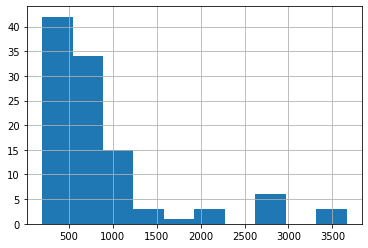

In [13]:
# Составим графики распределения:
active_studs_checks_A = active_studs_checks.query('grp == "A"').rev.hist()

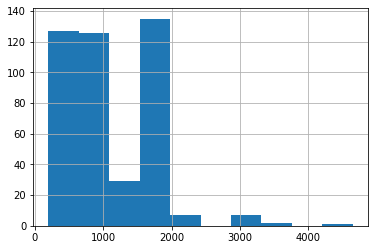

In [14]:
active_studs_checks_B = active_studs_checks.query('grp == "B"').rev.hist()

In [ ]:
# Видим, что распределения ярко выражено скошены влево и имеются выбросы.
# Чтобы проверить запускать ли новую механику на всех пользователей или нет мы посмотрим
# на две целевые метрики: среднее и конверсию в покупку
# С помощью бутстрапа мы проверим нулевую гипотезу о равенстве средних.
# Нулевая гипотеза (H0): Разницы между средним чеком в тестовой (B) и контрольной (A) группе нет
# Альтернативная гипотеза (H1): Разница между средним чеком в тестовой (B) и контрольной (A) группе есть

In [29]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=5,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"ci": ci, 
            "p_value": p_value}

In [30]:
active_studs_checks = active_studs_checks.fillna(0)  # заменим наны на нули

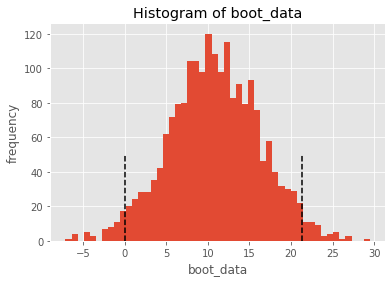

{'ci':                0
 0.025   0.103937
 0.975  21.288607,
 'p_value': 0.0458505993424505}

In [31]:
get_bootstrap(
    active_studs_checks[active_studs_checks.grp == 'B'].rev,  # числовые значения тестовой выборки
    active_studs_checks[active_studs_checks.grp == 'A'].rev,  # числовые значения контрольной выборки
    boot_it=2000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
)

In [ ]:
# Применяя бутстрап с оценкой среднего отклоняем нулевую гипотезу о равенстве средних,
# так как доверительный интервал для разницы средних не включает 0, это означает,
# что средние значимо отличаются и делаем вывод,
# что тестовая и контрольная выборка имеют различия, различия считаются статестически достоверными,
# так как p-value 0.04585 < 0,05

In [ ]:
# СR активного пользователя в покупку

In [20]:
# кол-во активных юзеров, совершивших покупку
active_studs_with_rev = active_studs_checks.query('rev != 0.0') \
                                            .groupby(['grp'], as_index=False) \
                                            .agg({'id': 'count'})
active_studs_with_rev

,grp,id
0,A,107
1,B,434


In [21]:
# кол-во всех активных юзеров
active_studs_all = active_studs_checks.groupby(['grp'], as_index=False) \
                                        .agg({'id': 'count'})
active_studs_all

,grp,id
0,A,1567
1,B,6923


In [22]:
CR_activ = active_studs_with_rev.id / active_studs_all.id
CR_activ

0    0.068283
1    0.062690
Name: id, dtype: float64

In [ ]:
# Проверим, есть ли различия в конверсиях в покупку в разных группах
# Для проверки этой гипотезы я использую хи-квадрат, поскольку переменные будут обе категориальные (купил/не купил, А/В).

In [23]:
# сделаем новую колонку в которой, будет храниться информация о покупке, False=не купил, true=купил
active_studs_checks['status_rev'] = active_studs_checks.rev > 0 
active_studs_checks.head()

,id,rev,grp,status_rev
0,581585,0.0,A,False
1,5723133,0.0,A,False
2,3276743,0.0,B,False
3,4238589,0.0,A,False
4,4475369,0.0,B,False


/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


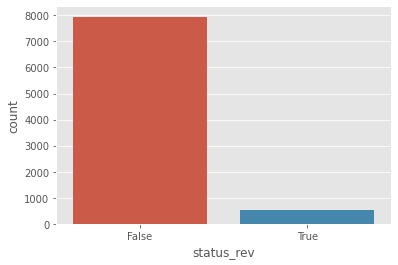

In [24]:
sns.countplot('status_rev', data=active_studs_checks)  # посмотрим на первую переменную, сколько купили/не купили

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


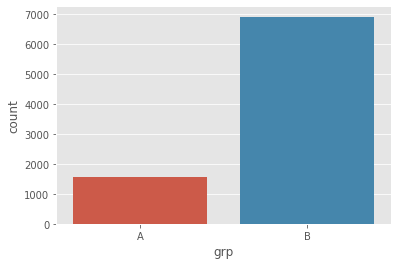

In [25]:
sns.countplot('grp', data=active_studs_checks)  # посмотрим на вторую переменную, сколько находится пользователей в каждой группе

In [26]:
# сделаем таблицу сопряженности, которая отражает связь двух категориальных переменных
tab = pd.crosstab(active_studs_checks.status_rev, active_studs_checks.grp)
print(tab)

grp            A     B
status_rev            
False       1460  6489
True         107   434


In [27]:
stat, p, dof, expected = chi2_contingency(tab)
print(p)

0.4464432666411111


In [ ]:
# Нулевая гипотеза не отклоняется, так как p-value > 0.05.

In [ ]:
# Вывод: Различие конверсий не значимо, т. е. количество покупающих юзеров считаем не изменилось,
# в то время как средний чек, который является главной метрикой изменился.
# Применяя бутстрап с оценкой среднего, мы отклонили нулевую гипотезу о равенстве средних
# и делаем вывод, что тестовая и контрольная выборка имеют различия.
# Следовательно нам стоит запускать новую механику оплаты на всех пользователей.

In [ ]:
# Задание 2. SQL
# 2.1 Очень усердные ученики.
# WITH

# -- найдем правильно решенные горошины за март месяц и пронумеруем строки

# step_1 AS (
#    SELECT
#        st_id,
#        timest,
#        row_number( ) OVER (PARTITION BY st_id ORDER BY  timest  ASC ) as num
#    FROM peas
#    WHERE
#        correct = 1
#        AND toMonth(timest) = 3
#    ),


# -- отфильтруем тех у кого время на решение заняло не более часа
#
# step_2 AS (
#    SELECT
#        A.st_id,
#        A.timest as starttime,
#        B.timest as endtime,
#        DATEDIFF(minute, A.timest, B.timest) as deltatime
#    FROM
#        step_1 as A
#    JOIN
#        step_1 as B
#    ON A.num+20=B.num
#        AND A.st_id=B.st_id
#    WHERE
#        DATEDIFF(minute, A.timest, B.timest) < 61
#    )
   
# SELECT
#    COUNT(DISTINCT st_id)
# FROM
#    step_2

# 2.2 Оптимизация воронки
# WITH
# step_1 AS (
#    -- найдем активных студентов
#    -- будем считать, что активный пользователь = усердный студент, который правильно решает 20 задач за текущий месяц
#    -- текущим месяцем будем считать последним месяц (31 день), информация о котором хранится в peas
#    SELECT
#        st_id,
#        SUM(correct) as correct1
#    FROM
#        peas
#    WHERE
#        DATEDIFF(day, timest, (SELECT MAX(timest) FROM default.peas)) <  32
#    GROUP BY
#        st_id
#    HAVING
#        correct1 > 1 --20
#    ),

# step_2 AS (
#    -- пропишем активный студент или нет, избавимся от задвоения в таблице studs и к какой группе относится  
#    SELECT
#        A.st_id,
#        A.test_grp,
#        CASE WHEN B.st_id='' THEN 0 ELSE 1 END AS activ
#    FROM
#        default.studs as A
#    LEFT JOIN
#        step_1 as B
#    ON
#        A.st_id = B.st_id
#    GROUP BY
#        A.st_id,
#        B.st_id,
#        A.test_grp
#    ),

# step_3 AS (
#     -- отфильтруем чеки последнего месяца
#    SELECT
#        st_id,
#        money,
#        subject,
#        sale_time
#    FROM
#        default.final_project_check
#    WHERE
#        DATEDIFF(day, sale_time, (SELECT MAX(timest) FROM default.peas)) <  32
#        AND DATEDIFF(day, sale_time, (SELECT MAX(timest) FROM default.peas)) > -1
#    ),

# step_4 AS (
#    -- присоединим чеки ко всем студентам с признаком активности        
#    SELECT
#        A.st_id,
#        A.test_grp,
#        A.activ,
#        B.money,
#        B.subject
#    FROM
#        step_2 as A
#    LEFT JOIN
#        step_3 as B
#    ON
#        A.st_id = B.st_id
#    )
   

# -- посчитаем метрики  
   
# SELECT
#    test_grp,
#   -- SUM(money) as all_profit,
#   -- COUNT(DISTINCT st_id) as all_stud,
#   -- SUM(CASE WHEN activ=0 THEN 0 ELSE money END) as sum_activ,
#   -- COUNT(DISTINCT CASE WHEN activ=0 THEN null ELSE st_id END) as count_activ,
#    -- COUNT(DISTINCT CASE WHEN money>0 THEN st_id ELSE null END) as count_stud_rev,
#   -- COUNT(DISTINCT CASE WHEN money>0 and activ=1 THEN st_id ELSE null END) as count_activ_stud_rev,
#   -- COUNT(DISTINCT CASE WHEN money>0 and activ=1 and subject = 'Math' THEN st_id ELSE null END) as count_actstud__math,
#   -- COUNT(DISTINCT CASE WHEN money>0 and subject = 'Math' THEN st_id ELSE null END) as count_stud__math
#   SUM(money) / COUNT(DISTINCT st_id) as ARPU,
#   SUM(CASE WHEN activ=0 THEN 0 ELSE money END) / COUNT(DISTINCT CASE WHEN activ=0 THEN null ELSE st_id END) as ARPAU,
#   COUNT(DISTINCT CASE WHEN money>0 THEN st_id ELSE null END) / COUNT(DISTINCT st_id) as CR,
#   COUNT(DISTINCT CASE WHEN money>0 and activ=1 THEN st_id ELSE null END) / COUNT(DISTINCT CASE WHEN activ=0 THEN null ELSE st_id END) as CR_activ,
#   COUNT(DISTINCT CASE WHEN money>0 and activ=1 and subject = 'Math' THEN st_id ELSE null END) / COUNT(DISTINCT CASE WHEN money>0 and subject = 'Math' THEN st_id ELSE null END) as CR_math

# FROM
#    step_4
# GROUP BY
#    test_grp

In [ ]:
# Задание 3. Python

In [28]:
groups_checks = groups.merge(checks, how='left', on=['id'])
way = "/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-sulimenko-18/Проект_2_group_add.csv"

In [29]:
def new_metrics(way):
    groups_add = pd.read_csv(way, sep=',')
    groups_add_checks = groups_add.merge(checks, how='left', on=['id'])
    groups_full_checks = pd.concat([groups_checks,groups_add_checks]) # присоединили дополнительные данные
    # посмотрим CR всех пользователей в покупку
    # кол-во юзеров, совершивших покупку
    groups_full_checks = groups_full_checks.fillna(0) # заменим наны на нули
    studs_with_rev = groups_full_checks.query('rev != 0.0') \
                                    .groupby(['grp'], as_index=False) \
                                    .agg({'id': 'count'})
    # кол-во всех юзеров
    studs_all = groups_full_checks.groupby(['grp'], as_index=False) \
                                .agg({'id': 'count'})
    CR = studs_with_rev.id/studs_all.id
    # посчитаем среднее
    mean_rev = active_studs_checks.groupby('grp', as_index=False).agg({'rev': 'mean'})
    
    #sns.countplot('grp', data = mean_rev)
    
    # Визуализируем

    fig=plt.figure(figsize=(18, 16), dpi= 10, facecolor='w')
    mean_rev.plot('grp', kind='bar', colormap='Blues_r')
    
    return {"CR": CR, 
            "mean_rev": mean_rev}

{'CR': 0    0.007282
 1    0.007247
 Name: id, dtype: float64,
 'mean_rev':   grp        rev
 0   A  58.772176
 1   B  69.511773}

<Figure size 180x160 with 0 Axes>

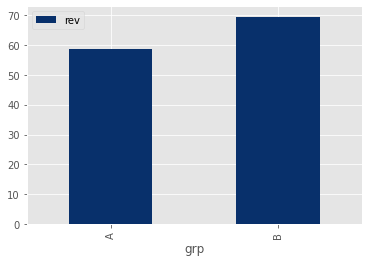

In [30]:
new_metrics("/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-sulimenko-18/Проект_2_group_add.csv")